<a href="https://colab.research.google.com/github/zhaodrago-cell/ECON5200-zilong-zhao-Applied-Data-Analytics-in-Econ-/blob/main/Econ_5200_Assignment_1/%20Assigment%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
student_basket = [
    {'Item': 'Tuition', 'Price_2016': 45000, 'Price_2024': 58000},
    {'Item': 'Rent (1 Bed)', 'Price_2016': 1200, 'Price_2024': 1800},
    {'Item': 'Chipotle Burrito', 'Price_2016': 7.50, 'Price_2024': 11.50},
    # ... add 1 more item
]

In [2]:
def calculate_inflation(base, current):
    return ((current - base) / base) * 100

for item in student_basket:
    rate = calculate_inflation(item['Price_2016'], item['Price_2024'])
    print(f"{item['Item']}: {rate:.2f}% Inflation")


Tuition: 28.89% Inflation
Rent (1 Bed): 50.00% Inflation
Chipotle Burrito: 53.33% Inflation


In [10]:
!pip install fredapi
import pandas as pd
from fredapi import Fred
fred = Fred(api_key='dd6d1eee7919ddf744060754fd1c114b')



In [11]:
series_map = {
    "Official_CPI": "CPIAUCSL",
    "Tuition_Fees": "CUSR0000SEEB",
    "Rent_Primary_Residence": "CUSR0000SEHA",
    "Cable_Streaming_TV": "CUSR0000SERA02",
    "Food_Away_From_Home": "CUSR0000SEFV"
}

In [14]:
df = pd.DataFrame({name: fred.get_series(code) for name, code in series_map.items()})
df.index = pd.to_datetime(df.index)
df = df[df.index >= "2016-01-01"]
df.tail()


,Official_CPI,Tuition_Fees,Rent_Primary_Residence,Cable_Streaming_TV,Food_Away_From_Home
2025-08-01,323.364,895.305,437.462,592.604,384.909
2025-09-01,324.368,897.302,438.322,593.928,385.451
2025-10-01,NaN,NaN,NaN,NaN,NaN
2025-11-01,325.031,902.001,438.875,599.226,387.202
2025-12-01,326.030,903.402,440.034,605.825,389.889


In [15]:
start_date = "2016-01-01"
base_row = df.loc[df.index >= start_date].iloc[0]
df_norm = (df / base_row) * 100
df_norm.head()

,Official_CPI,Tuition_Fees,Rent_Primary_Residence,Cable_Streaming_TV,Food_Away_From_Home
2016-01-01,100.000000,100.000000,100.000000,100.000000,100.000000
2016-02-01,99.867032,100.241572,100.314364,100.723912,100.138869
2016-03-01,100.180095,100.470288,100.607131,101.450163,100.355827
2016-04-01,100.563850,100.692146,100.924580,101.878663,100.599712
2016-05-01,100.801592,100.929861,101.258485,102.214306,100.813978


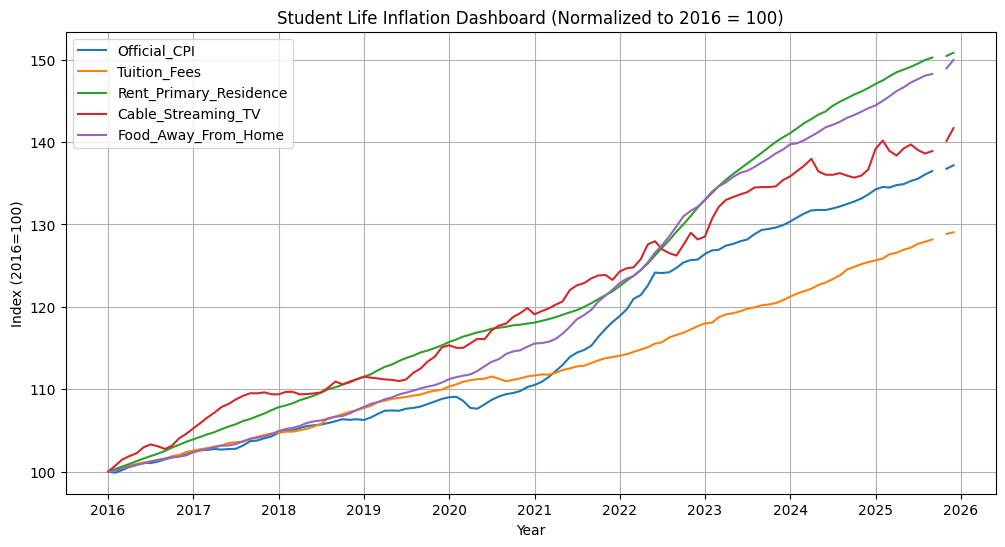

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for col in df_norm.columns:
    plt.plot(df_norm.index, df_norm[col], label=col)

plt.title("Student Life Inflation Dashboard (Normalized to 2016 = 100)")
plt.xlabel("Year")
plt.ylabel("Index (2016=100)")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
 weights = {
    "Tuition_Fees": 0.40,
    "Rent_Primary_Residence": 0.30,
    "Food_Away_From_Home": 0.20,
    "Cable_Streaming_TV": 0.10
}
df_norm["Student_SPI"] = sum(df_norm[k] * w for k, w in weights.items())

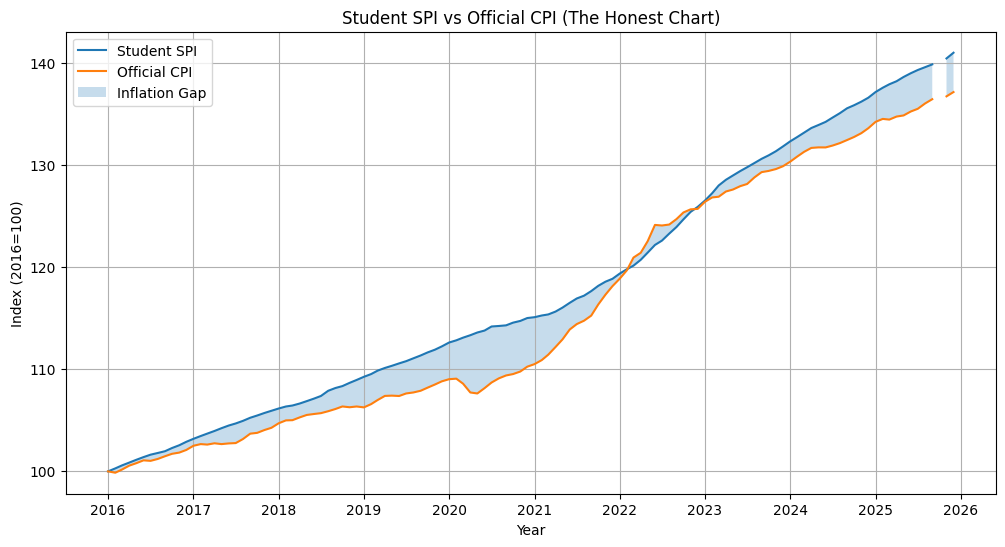

In [19]:
plt.figure(figsize=(12,6))

plt.plot(df_norm.index, df_norm["Student_SPI"], label="Student SPI")
plt.plot(df_norm.index, df_norm["Official_CPI"], label="Official CPI")

plt.fill_between(
    df_norm.index,
    df_norm["Student_SPI"],
    df_norm["Official_CPI"],
    alpha=0.25,
    label="Inflation Gap"
)

plt.title("Student SPI vs Official CPI (The Honest Chart)")
plt.xlabel("Year")
plt.ylabel("Index (2016=100)")
plt.legend()
plt.grid(True)
plt.show()

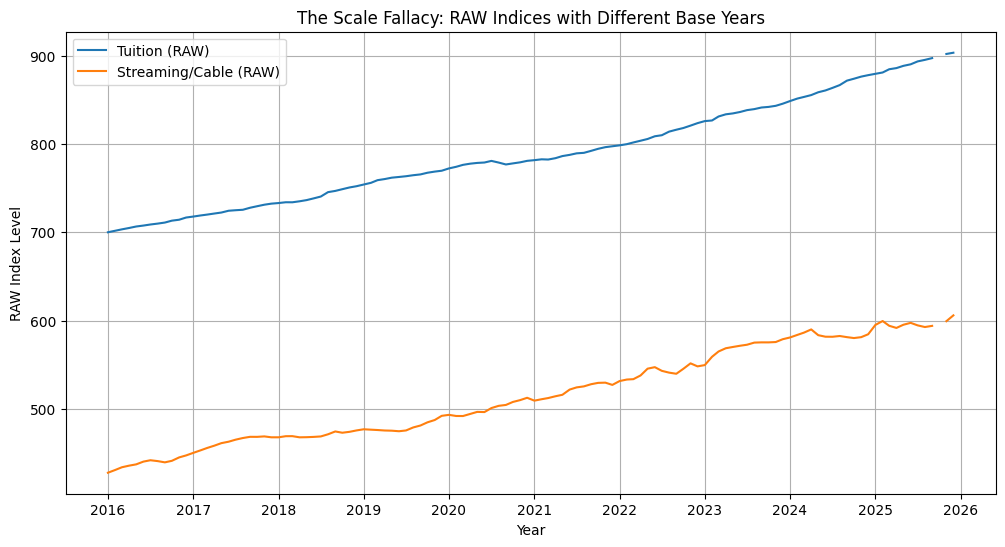

In [20]:
plt.figure(figsize=(12,6))

plt.plot(df.index, df["Tuition_Fees"], label="Tuition (RAW)")
plt.plot(df.index, df["Cable_Streaming_TV"], label="Streaming/Cable (RAW)")

plt.title("The Scale Fallacy: RAW Indices with Different Base Years")
plt.xlabel("Year")
plt.ylabel("RAW Index Level")
plt.legend()
plt.grid(True)
plt.show()

This raw chart is misleading because the CPI series use different base years, which changes the size of the index. For example: The Tuition CPI can look very large because it uses an older base year (like 1982 = 100), so the index has had more time to grow. The Streaming CPI can look much smaller because it uses a newer base year (like 2002 = 100). The correct solution is normalization 。 Set all series to 2016 = 100, so we can compare their growth fairly.

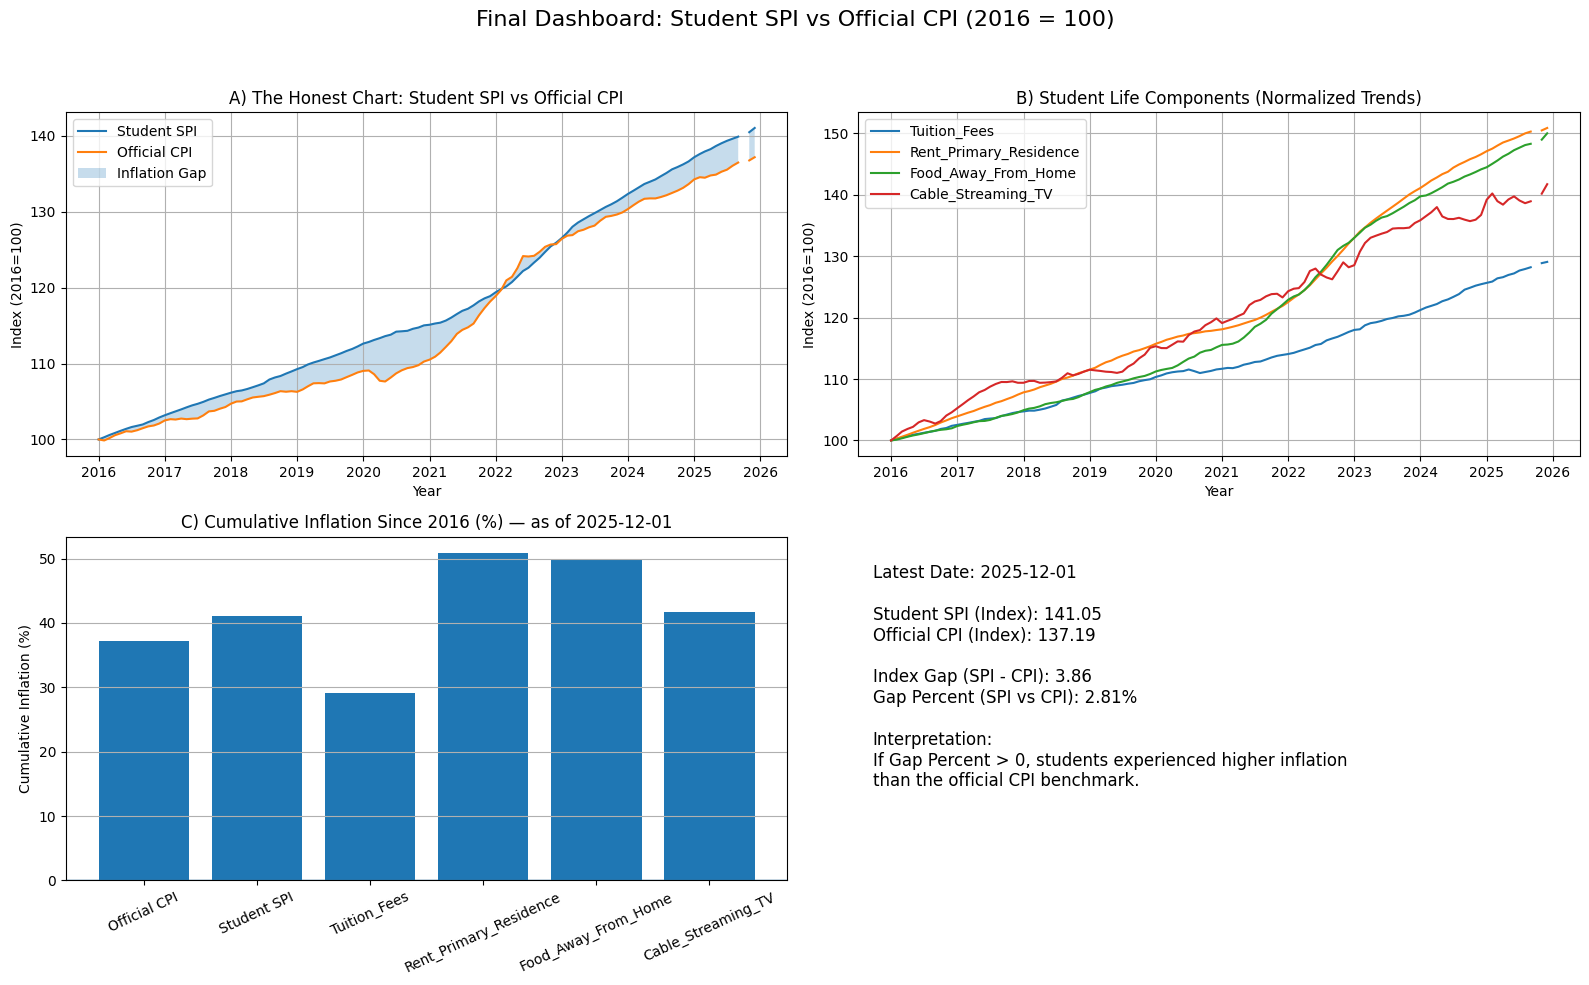

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# ----------------------------
# 0) Safety checks
# ----------------------------
required_cols = [
    "Official_CPI",
    "Tuition_Fees",
    "Rent_Primary_Residence",
    "Food_Away_From_Home",
    "Cable_Streaming_TV",
    "Student_SPI"
]

missing = [c for c in required_cols if c not in df_norm.columns]
if missing:
    raise ValueError(f"Missing columns in df_norm: {missing}")

# Use last available date
latest_date = df_norm.dropna().index[-1]
latest = df_norm.loc[latest_date]

# Components to show
components = [
    "Tuition_Fees",
    "Rent_Primary_Residence",
    "Food_Away_From_Home",
    "Cable_Streaming_TV"
]

# ----------------------------
# 1) Helper metrics (2016=100 base)
# ----------------------------
def cumulative_inflation(index_value):
    # since base = 100, cumulative inflation = (Index/100 - 1)*100
    return (index_value / 100 - 1) * 100

cum_official = cumulative_inflation(latest["Official_CPI"])
cum_student  = cumulative_inflation(latest["Student_SPI"])

cum_components = {c: cumulative_inflation(latest[c]) for c in components}

gap_index = latest["Student_SPI"] - latest["Official_CPI"]
gap_percent = (latest["Student_SPI"] / latest["Official_CPI"] - 1) * 100

# ----------------------------
# 2) Build 2x2 Dashboard
# ----------------------------
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle("Final Dashboard: Student SPI vs Official CPI (2016 = 100)", fontsize=16)

# (A) Student SPI vs Official CPI + Gap fill
ax = axes[0, 0]
ax.plot(df_norm.index, df_norm["Student_SPI"], label="Student SPI")
ax.plot(df_norm.index, df_norm["Official_CPI"], label="Official CPI")

ax.fill_between(
    df_norm.index,
    df_norm["Student_SPI"],
    df_norm["Official_CPI"],
    alpha=0.25,
    label="Inflation Gap"
)

ax.set_title("A) The Honest Chart: Student SPI vs Official CPI")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2016=100)")
ax.grid(True)
ax.legend()

# (B) Normalized components trend
ax = axes[0, 1]
for c in components:
    ax.plot(df_norm.index, df_norm[c], label=c)

ax.set_title("B) Student Life Components (Normalized Trends)")
ax.set_xlabel("Year")
ax.set_ylabel("Index (2016=100)")
ax.grid(True)
ax.legend()

# (C) Cumulative inflation since 2016 (%)
ax = axes[1, 0]
bar_labels = ["Official CPI", "Student SPI"] + components
bar_values = [cum_official, cum_student] + [cum_components[c] for c in components]

ax.bar(bar_labels, bar_values)
ax.axhline(0, linewidth=1)
ax.set_title(f"C) Cumulative Inflation Since 2016 (%) — as of {latest_date.date()}")
ax.set_ylabel("Cumulative Inflation (%)")
ax.tick_params(axis="x", rotation=25)
ax.grid(True, axis="y")

# (D) Gap summary (Index gap + % gap)
ax = axes[1, 1]
ax.axis("off")

summary_text = f"""
Latest Date: {latest_date.date()}

Student SPI (Index): {latest['Student_SPI']:.2f}
Official CPI (Index): {latest['Official_CPI']:.2f}

Index Gap (SPI - CPI): {gap_index:.2f}
Gap Percent (SPI vs CPI): {gap_percent:.2f}%

Interpretation:
If Gap Percent > 0, students experienced higher inflation
than the official CPI benchmark.
"""

ax.text(0.02, 0.98, summary_text, va="top", fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

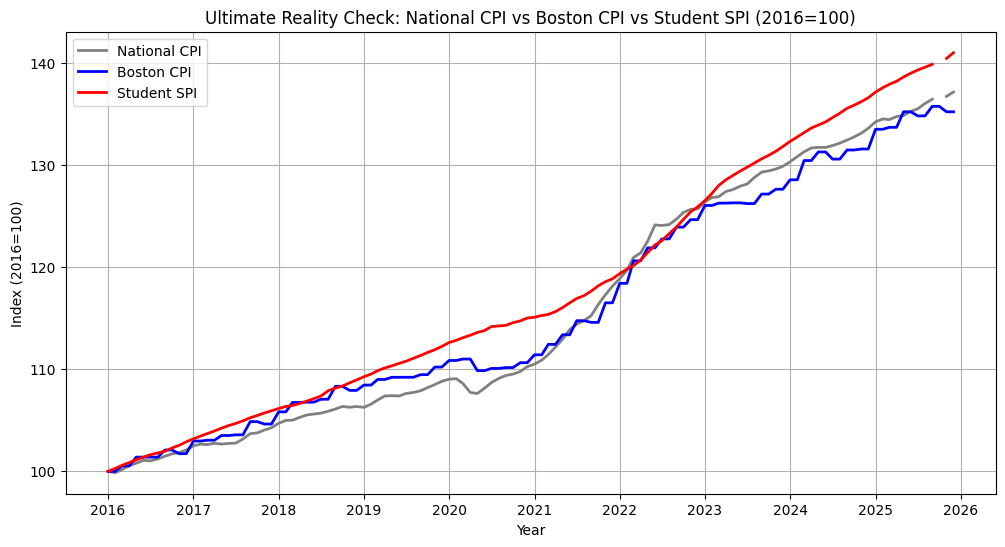

In [24]:
from fredapi import Fred
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Connect FRED
# ----------------------------
fred = Fred(api_key="dd6d1eee7919ddf744060754fd1c114b")

# ----------------------------
# 2) Fetch Boston CPI (All Items)
# ----------------------------
boston_raw = fred.get_series("CUURA103SA0")  # Boston-Cambridge-Newton CPI (monthly, NSA)
boston_raw.index = pd.to_datetime(boston_raw.index)

# ----------------------------
# 3) Normalize to 2016=100
# ----------------------------
start_date = "2016-01-01"
boston_base = boston_raw.loc[boston_raw.index >= start_date].iloc[0]
boston_norm = (boston_raw / boston_base) * 100
boston_norm.name = "Boston_CPI"

# ----------------------------
# 4) Merge with your existing df_norm
#    df_norm must already contain: "Official_CPI" and "Student_SPI"
# ----------------------------
plot_df = df_norm[["Official_CPI", "Student_SPI"]].join(boston_norm, how="outer").sort_index()

# Boston CPI is often bi-monthly -> missing months appear as NaN
# Fill missing Boston values so the line is continuous
plot_df["Boston_CPI"] = plot_df["Boston_CPI"].ffill()

# Keep only 2016+
plot_df = plot_df.loc[plot_df.index >= start_date]

# ----------------------------
# 5) Plot 3 lines (National vs Boston vs Student)
# ----------------------------
plt.figure(figsize=(12,6))

plt.plot(plot_df.index, plot_df["Official_CPI"], label="National CPI", color="grey", linewidth=2)
plt.plot(plot_df.index, plot_df["Boston_CPI"], label="Boston CPI", color="blue", linewidth=2)
plt.plot(plot_df.index, plot_df["Student_SPI"], label="Student SPI", color="red", linewidth=2)

plt.title("Ultimate Reality Check: National CPI vs Boston CPI vs Student SPI (2016=100)")
plt.xlabel("Year")
plt.ylabel("Index (2016=100)")
plt.grid(True)
plt.legend()
plt.show()

